In [1]:
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import fTNModel, fTN_NN_proj_variable_Model
from vmc_torch.experiment.tn_model import fTN_Transformer_Model, fTN_Transformer_Proj_lazy_Model
from vmc_torch.experiment.tn_model import init_weights_xavier, init_weights_kaiming, init_weights_to_zero
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless, MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import TrivialPreconditioner, SignedSGD, SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice, spinless_Fermi_Hubbard_square_lattice
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(16)
symmetry = 'U1'
t = 1.0
U = 8.0
N_f = int(Lx*Ly-8)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = -1
dtype=torch.float64

# Load PEPS
skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
peps = qtn.unpack(peps_params, skeleton)
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = 2000
N_samples = N_samples - N_samples % SIZE + SIZE
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

model = fTNModel(peps, max_bond=chi)
model.apply(lambda x: init_weights_to_zero(x, std=2e-2))

model_names = {
    fTNModel: 'fTN',
    fTN_Transformer_Model: 'fTN_Transformer',
    fTN_Transformer_Proj_lazy_Model: 'fTN_Transformer_Proj_lazy',
    fTN_NN_proj_variable_Model: 'fTN_NN_proj_variable',
    
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
total_steps = 200
if init_step != 0:
    saved_model_params = torch.load(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
optimizer = SGD(learning_rate=0.05)
sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=1, reset_chain=False, random_edge=False, equal_partition=False, dtype=dtype)
# sampler = None
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# preconditioner = TrivialPreconditioner()
vmc = VMC(H, variational_state=variational_state, optimizer=optimizer, preconditioner=preconditioner)

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model.num_params

8608

In [3]:
import jax
import pyinstrument
random_config = H.hilbert.random_state(key=jax.random.PRNGKey(1))
random_config = torch.tensor(random_config, dtype=dtype)
amp = peps.get_amp(random_config)
model(random_config), amp.contract()

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(tensor([2.4401e-52], dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor(2.4401e-52, dtype=torch.float64))

In [9]:
import cotengra as ctg
opt = ctg.ReusableHyperOptimizer()
amp.contraction_cost(optimize=opt)

520588

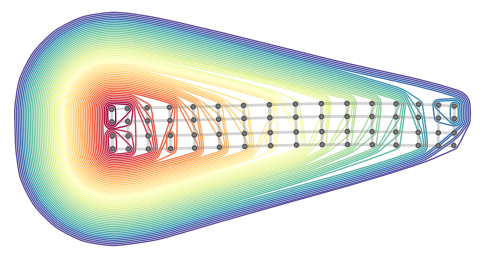

(<Figure size 600x400 with 1 Axes>, <Axes: >)

In [10]:
tree = amp.contraction_tree(optimize=opt)
tree.plot_rubberband(figsize=(6, 4))

In [14]:
amp.contract(optimize=tree)

tensor(2.4401e-52, dtype=torch.float64)

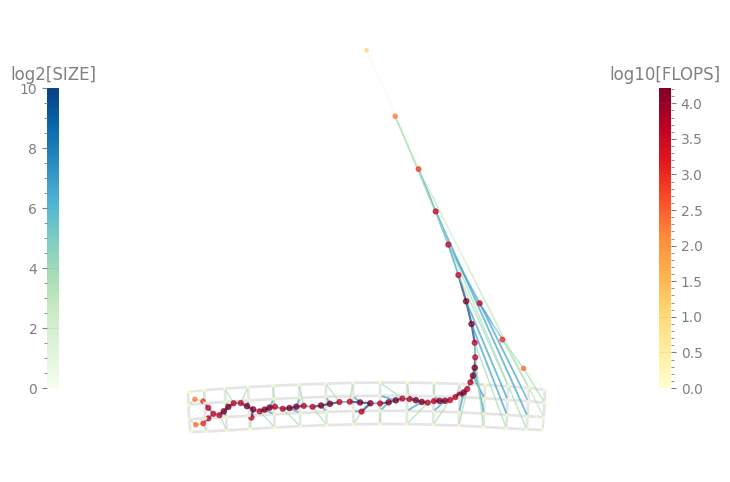

(<Figure size 600x600 with 3 Axes>, <Axes: >)

In [12]:
tree.plot_tent(figsize=(6, 6))

In [5]:
with pyinstrument.Profiler() as prof0:
    sampler.burn_in(variational_state)
prof0.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:43:17  Samples:  8595
 /_//_/// /_\ / //_// / //_'/ //     Duration: 8.749     CPU time: 8.749
/   _/                      v4.7.3

Profile at /tmp/ipykernel_24508/2592552576.py:1

8.748 <module>  ../../../../../tmp/ipykernel_24508/2592552576.py:1
└─ 8.748 MetropolisExchangeSamplerSpinful.burn_in  ../sampler.py:108
   └─ 8.748 MetropolisExchangeSamplerSpinful._sample_next  ../sampler.py:842
      └─ 8.732 wrapper  ../utils.py:39
         └─ 8.730 Variational_State.amplitude  ../variational_state.py:87
            └─ 8.730 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1549
                  [0 frames hidden]  
                     8.730 fTNModel._call_impl  torch/nn/modules/module.py:1555
                     └─ 8.730 fTNModel.forward  tn_model.py:533
                        └─ 8.677 fTNModel.amplitude  tn_model.py:785
                           ├─ 4.828 fPEPS.get_amp  ../fermion_utils.py:116
                           │  ├─ 4.

In [8]:
with pyinstrument.Profiler() as prof:
    model(random_config)
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 15:44:11  Samples:  176
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.178     CPU time: 0.179
/   _/                      v4.7.3

Profile at /tmp/ipykernel_4515/1791513093.py:1

0.178 <module>  ../../../../../tmp/ipykernel_4515/1791513093.py:1
└─ 0.178 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1549
      [0 frames hidden]  
         0.178 fTNModel._call_impl  torch/nn/modules/module.py:1555
         └─ 0.178 fTNModel.forward  tn_model.py:532
            └─ 0.177 fTNModel.amplitude  tn_model.py:783
               ├─ 0.077 fPEPS.get_amp  ../fermion_utils.py:116
               │  ├─ 0.071 TensorNetwork.contract  quimb/tensor/tensor_core.py:8438
               │  │  └─ 0.071 TensorNetwork.contract_tags  quimb/tensor/tensor_core.py:8328
               │  │     ├─ 0.067 wrapper  functools.py:883
               │  │     │  └─ 0.067 tensor_contract  quimb/tensor/tensor_core.py:207
               │  │     │     └─ 0.066 array_cont